# Emojii embeddings

In [1]:
#!pip install emoji

In [34]:
import pandas as pd
import emoji

In [35]:
data = pd.read_csv("/Users/macbook/emoji_prediction/data/full_df_twi_tg.csv")
print(data.shape)
print(len(data[data.duplicated(subset=['texts', 'time', 'source']) == True]))

(374595, 6)
182830


In [36]:
data.dtypes

texts      object
names      object
time       object
channel    object
source     object
emoji      object
dtype: object

In [37]:
data.head(1)

,texts,names,time,channel,source,emoji
0,😎,Mandarina,16.10.2018 10:40:46,msk24,Telegram,😎


In [38]:
data_unique = data.drop_duplicates(subset=['texts', 'time', 'source'], keep='first')

In [39]:
data_unique.shape

(191765, 6)

In [40]:
# unique emojis unicode
emojis = list(emoji.UNICODE_EMOJI.keys())
#emojis = [str(e) for e in emojis]
unicodes = [e.encode('unicode-escape').decode("utf-8")  for e in emojis]

In [41]:
len(emojis)

2623

In [42]:
# preprocessing texts: stemming, Username|URL standartization, decoding emojis to utf
import re
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize

def getCleanData(df):
    
    df['texts'] = df['texts']\
    .apply(
        lambda x: re.sub(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", 
                         "@username", x)
    )\
    .apply(
        lambda x: re.sub(r"([0-9]{1,3}\\.[0-9]{1,3}\\.[0-9]{1,3}\\.[0-9]{1,3}|((news|telnet|nttp|file|http|ftp|https)://)|(www|ftp)[-A-Za-z0-9]*\\.)[-A-Za-z0-9\\.]+(:[0-9]*)?/[-A-Za-z0-9_\\$\\.\\+\\!\\*\\(\\),;:@&=\\?/~\\#\\%]*[^]'\\.}>\\),\\\"]", 
                         "URL", x)
    )\
    .str.replace("\n", " ")\
    .str.replace("RT @username", "")
    return df

def tokenizeData(df):
    m = Mystem()
#     emojis = list(emoji.UNICODE_EMOJI.keys())
#     df['texts'] = [t.replace(e, f" {str(e)} ") if e in t and type(t) == str else t 
#                      for t in df['texts'] for e in emojis]
    
    tokenized_texts = df['texts'].apply(lambda x: m.lemmatize(x))
    df['texts'] = df['texts'].apply(lambda x: " ".join(m.lemmatize(x)))
    df['texts'] = df['texts'].apply(lambda x: re.sub('\s+', ' ', x).strip())
    return df, tokenized_texts


In [43]:
%%time
data_clean = getCleanData(data_unique)
print(data_clean.shape)

(191765, 6)
CPU times: user 2.15 s, sys: 32.8 ms, total: 2.18 s
Wall time: 2.22 s


/Users/macbook/.pyenv/versions/3.6.7/envs/venv367/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
%%time
data_clean, tokenized_texts = tokenizeData(data_clean)

/Users/macbook/.pyenv/versions/3.6.7/envs/venv367/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 33.8 s, sys: 5.74 s, total: 39.5 s
Wall time: 3min 21s


/Users/macbook/.pyenv/versions/3.6.7/envs/venv367/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
texts = data_clean['texts'].tolist()

In [46]:
texts[900:910]

['ахахах я сегодня гарь хотеть пересматривать весь 😁 ждать сториза в инстаграмма',
 'хорошо 😂 я хз что это но должно быть интересно )',
 'гари потер ну 😁',
 'да , я понимать ) пересматривать 😂 я давно не смотреть .. чуять , проигрывать мы 😂',
 '😂 😂 😂',
 'надо быть в скорый время сходить в барчик 😏',
 'ниховать весь шарить 😂',
 'у я с ты фотка в вк стоять , все я задавать вопрос это што твой паринь 🤣 🤣 🤣 🤣 🤣',
 '🤔 какой интересный интерпретация',
 '😉']

## Word2Vec: CBOW

In [64]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

model_CBOW = Word2Vec(texts, size=300, window=3, min_count=4, workers=4)

In [65]:
model_CBOW.corpus_total_words

8335686

In [67]:
model_CBOW.wv.most_similar('😘', topn=10)

[('\U0001f970', 0.6127868890762329),
 ('🤗', 0.6075960397720337),
 ('😗', 0.606320321559906),
 ('😙', 0.6052931547164917),
 ('😍', 0.5938857197761536),
 ('💛', 0.5561263561248779),
 ('☻', 0.5271309018135071),
 ('💐', 0.52568119764328),
 ('😽', 0.5247597694396973),
 ('😇', 0.5199021100997925)]

In [68]:
model_CBOW.save("./models/word2vec_CBOW_new.model")

In [69]:
model_CBOW_token = Word2Vec(tokenized_texts, size=300, window=5, min_count=4, workers=4)
print(model_CBOW_token.corpus_total_words)
print(model_CBOW_token.wv.most_similar('😘'))

3062549
[('❤️\n', 0.7106764316558838), ('солнышко', 0.70790034532547), ('малышка', 0.6667879819869995), ('целовать', 0.6664431691169739), ('обнимать', 0.6572937965393066), ('систр', 0.655383288860321), ('💖', 0.6431198120117188), ('подтянутый', 0.6424639821052551), ('приветик', 0.639851987361908), ('😽', 0.638516902923584)]


In [70]:
similars = [{e: model_CBOW.wv.most_similar(e)} for e in emojis if e in model_CBOW.wv.vocab]

In [71]:
import json
with open('./similar_emojis_w2v_CBOW_new.json', 'w') as outfile:
    json.dump(similars, outfile)
    outfile.close()

## Word2Vec: Skip-gram

In [72]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

model_skip = Word2Vec(texts, size=300, window=5, min_count=4, workers=4, sg=1)

In [73]:
model_skip.corpus_total_words

8335686

In [74]:
model_skip.wv.most_similar('😘')

[('🤗', 0.5284894704818726),
 ('💘', 0.5272725820541382),
 ('🍁', 0.5231646299362183),
 ('😙', 0.5160070657730103),
 ('🌠', 0.505496621131897),
 ('💋', 0.493554949760437),
 ('😗', 0.48782065510749817),
 ('🙌', 0.48606058955192566),
 ('😚', 0.4839693307876587),
 ('😍', 0.479634165763855)]

In [75]:
model_skip.save("./models/word2vec_SkipGram_new.model")

In [76]:
similars_skip = [{e: model_skip.wv.most_similar(e)} for e in emojis if e in model_skip.wv.vocab]

In [77]:
for e in range(0,len(similars_skip)):
    e_similar = []
    index = list(similars_skip[e].keys())[0]
    for i in similars_skip[e][index]:
        if i[0] in emojis:
            e_similar.append(i)

    similars_skip.append({index: e_similar})

In [78]:
import json
with open('./similar_emojis_w2v_SkipGram_new.json', 'w') as outfile:
    json.dump(similars_skip, outfile)
    outfile.close()

## Visualizing embeddings in 2d: TSNE

In [145]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
rcParams['font.family'] = ['Apple Color Emoji']


from pylab import *

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = [e for e in tsne_emojis['index'].tolist() if e in model.wv.vocab]
    tokens = [model.wv[e] for e in tsne_emojis['index'].tolist() if e in model.wv.vocab]

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/macbook/.pyenv/versions/3.6.7/envs/venv367/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Apple Color Emoji'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


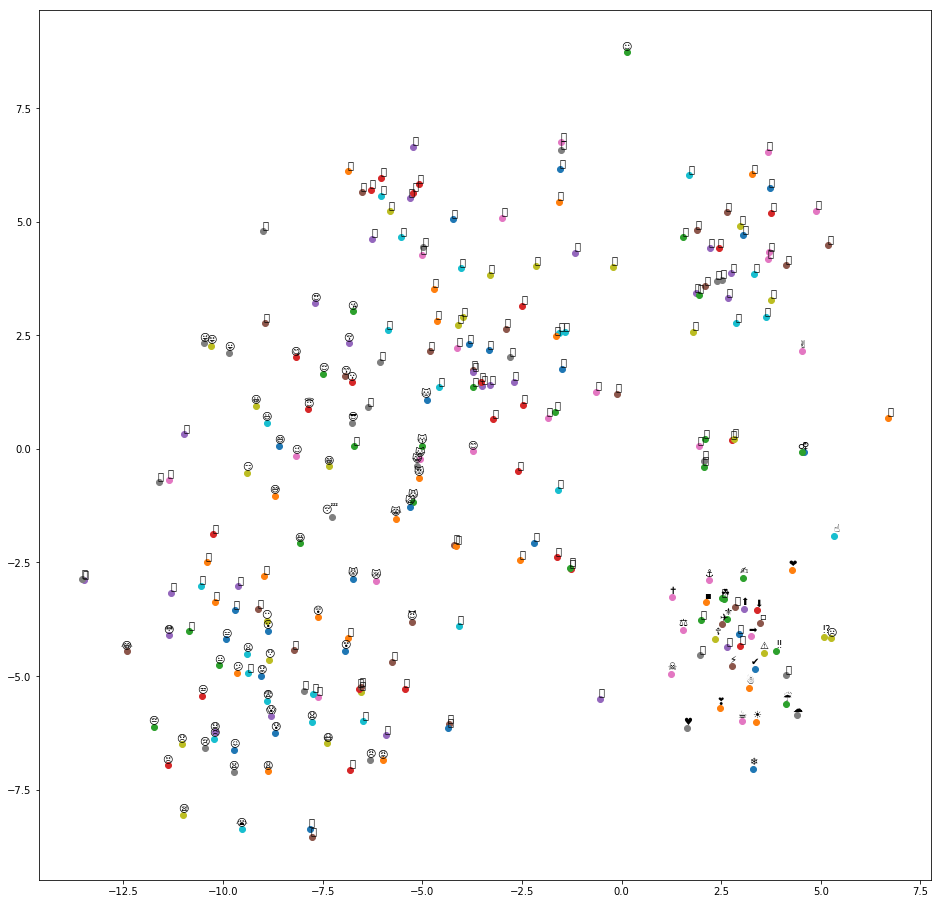

In [146]:
tsne_plot(model_CBOW)

## Clustering emojis: KMeans, Affinity propagation, DBSCAN

### Spoiler: KMeans wins

In [92]:
emojis_found = [e for e in emojis if e in model_CBOW.wv.vocab]

In [93]:
X = [model_CBOW.wv[e] for e in emojis if e in model_CBOW.wv.vocab]

In [94]:
len(X)

813

In [95]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

for n_cluster in range(2, 19):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.4866989552974701
For n_clusters=3, The Silhouette Coefficient is 0.4839714765548706
For n_clusters=4, The Silhouette Coefficient is 0.4708152413368225
For n_clusters=5, The Silhouette Coefficient is 0.47529521584510803
For n_clusters=6, The Silhouette Coefficient is 0.4292636215686798
For n_clusters=7, The Silhouette Coefficient is 0.4325534403324127
For n_clusters=8, The Silhouette Coefficient is 0.45732012391090393
For n_clusters=9, The Silhouette Coefficient is 0.3942079544067383
For n_clusters=10, The Silhouette Coefficient is 0.31672343611717224
For n_clusters=11, The Silhouette Coefficient is 0.28238755464553833
For n_clusters=12, The Silhouette Coefficient is 0.3446815311908722
For n_clusters=13, The Silhouette Coefficient is 0.4254491627216339
For n_clusters=14, The Silhouette Coefficient is 0.4218636751174927
For n_clusters=15, The Silhouette Coefficient is 0.20952802896499634
For n_clusters=16, The Silhouette Coefficient is 0.

In [140]:
from sklearn.cluster import KMeans
import numpy as np

k_means = KMeans(n_clusters=14, random_state=1)
k_means.fit(X)
k_means_labels = k_means.labels_ # array with cluster of emojis (concat to df)


k_means_labels_unique = np.unique(k_means_labels)
k_means_cluster_centers = k_means.cluster_centers_

In [141]:
emo_clusters = pd.DataFrame(k_means_labels, index=emojis_found, columns=['cluster_group']).reset_index()

In [142]:
emo_clusters.groupby('cluster_group').agg('count')

,index
cluster_group,
0,5
1,567
2,30
3,34
4,2
5,31
6,38
7,2
8,34


In [143]:
tsne_emojis = emo_clusters[(emo_clusters.cluster_group != 1)]

In [139]:
emo_clusters[emo_clusters.cluster_group == 15]

,index,cluster_group


In [147]:
emo_clusters.to_csv("./emo_clusters14.csv", index=False)

### Affinity propagation

In [156]:
clust_1 = emo_clusters['index'][emo_clusters.cluster_group == 1].tolist()

clust_1_embed = {}
for e in clust_1:
    if e in model_CBOW.wv.vocab:
        clust_1_embed[e] = model_CBOW.wv[e]
        
X_clust_1 = list(clust_1_embed.values())

In [158]:
from sklearn.cluster import AffinityPropagation

aff = AffinityPropagation(damping=0.9, max_iter=200, convergence_iter=15, copy=True, 
                                    preference=None, affinity="euclidean", verbose=False)
aff_matr = aff.fit_predict(X_clust_1)
affinity_labels = aff.labels_

from sklearn.metrics import silhouette_score
mean_sil_aff = silhouette_score(X_clust_1, affinity_labels)

print("Mean silhouette score for Affinity propagation: " + str(mean_sil_aff))

Mean silhouette score for Affinity propagation: 0.059873402


### DBSCAN

In [159]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

db = DBSCAN(eps=0.3, min_samples=10).fit(X_clust_1)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 442
